In [1]:
# Essential libraries
import os
import random
import itertools
from itertools import product, combinations
import multiprocessing

# Numeric computation
import numpy as np
import torch
import scipy  # For linear algebra (e.g., Cholesky decomposition)
from scipy.spatial import ConvexHull, Delaunay # For sampling and NTR
from scipy.optimize import minimize #For projection to the NTR
from scipy.spatial.distance import pdist, squareform #For projection to the NTR
from scipy.special import roots_hermite # Polynomials of the form e^(-x^2)
from scipy.special import roots_hermitenorm # Polynomials of the form e^(-x^(2)/2)

# Gaussian Process Regression (GPR)
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import (Kernel, ScaleKernel, MaternKernel, 
                              GridInterpolationKernel, ProductKernel)
from gpytorch.utils.grid import choose_grid_size
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from torch.nn import ModuleList  # Correct import for ModuleList (For SKIP)
from gpytorch.variational import (CholeskyVariationalDistribution, 
                                  VariationalStrategy)  # For SVGP
from gpytorch.lazy import MatmulLazyTensor, InterpolatedLazyTensor
from gpytorch.settings import fast_pred_var

# Optimization
import cyipopt
from cyipopt import Problem

# Quasi-Monte Carlo (QMC) and sparse grids
import Tasmanian  # Tasmanian Sparse Grid library
from torch.quasirandom import SobolEngine
import chaospy as cp

# We can save our No-trade-regions (Convex hulls) as .pkl files
import pickle
    #Save
    # with open("convex_hulls_array.pkl", "wb") as file:
    #     pickle.dump(convex_hulls, file)
    #Open
    # with open("convex_hulls_array.pkl", "rb") as file:
    #     loaded_hulls = pickle.load(file)


# Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
import scienceplots  # For custom style based on science plots

# Parallel processing
from joblib import Parallel, delayed

# Logging configuration
import logging
logging.basicConfig(filename='optimization_log.txt', 
                    filemode='w',
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Random seed setup
random_seed = 121001
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
multiprocessing.set_start_method('spawn', force=True)

In [3]:
plt.style.use('science')

custom = True
if custom:

    colors = ['#094a84','#cc2300', 
                '#009437', '#cc7700',
                '#694878', '#383838',
                '#7e7e7e']
    mpl.rcParams['axes.prop_cycle'] = cycler('color', 
                                            ['#094a84','#cc2300', 
                                            '#009437', '#cc7700',
                                            '#694878', '#383838',
                                            '#7e7e7e'])

    mpl.rcParams['figure.facecolor'] = '#ffffff'  # Lightest Snow Storm background
    mpl.rcParams['axes.facecolor'] = '#FCFDFE'    # Same light background inside plots
    mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.facecolor'] = '#3B4252'    # Same light background inside plots
    # # mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.edgecolor'] = '#3B4252'    # Dark Slate from Polar Night for edges
    # mpl.rcParams['axes.labelcolor'] = '#3B4252'   # Text color for labels using Dark Slate
    # mpl.rcParams['xtick.color'] = '#3B4252'       # Tick color from Polar Night palette
    # mpl.rcParams['ytick.color'] = '#3B4252'

    mpl.rcParams['font.size'] = 11
    mpl.rcParams['axes.titlesize'] = 11
    mpl.rcParams['axes.labelsize'] = 11
    mpl.rcParams['legend.fontsize'] = 11

    # Remove spines
    # mpl.rcParams['axes.spines.top'] = False
    # mpl.rcParams['axes.spines.right'] = False
    # mpl.rcParams['axes.spines.bottom'] = False
    # mpl.rcParams['axes.spines.left'] = False

    # Grid settings
    mpl.rcParams['axes.grid'] = True
    mpl.rcParams['grid.color'] = '#e2e3e4'        # Subtle grid lines using light Snow Storm color
    mpl.rcParams['grid.linestyle'] = '--'
    mpl.rcParams['grid.linewidth'] = 0.8
    mpl.rcParams['axes.titlecolor'] = 'black'
    # Ticks
    mpl.rcParams['xtick.major.size'] = 5
    mpl.rcParams['ytick.major.size'] = 5
    mpl.rcParams['xtick.minor.size'] = 3
    mpl.rcParams['ytick.minor.size'] = 3
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.direction'] = 'in'

    # Lines and markers
    mpl.rcParams['lines.linewidth'] = 3
    mpl.rcParams['lines.markersize'] = 6
    mpl.rcParams['lines.markeredgewidth'] = 1.5

    # Legends
    mpl.rcParams['legend.frameon'] = True
    mpl.rcParams['legend.loc'] = 'best'
    # Subplots and layout
    mpl.rcParams['figure.figsize'] = [8, 6]
    mpl.rcParams['figure.dpi'] = 600
    mpl.rcParams['figure.autolayout'] = True

    # Always save as 'tight'
    mpl.rcParams['savefig.bbox'] = 'tight'
    mpl.rcParams['savefig.pad_inches'] = 0.02

    # Save figures to the folder Figures
    output_folder = '../Speciale dokumentet/Figures'
    os.makedirs(output_folder, exist_ok=True)

## Set parameters and load corresponding NTR solution

In [5]:
def load_ntr_array_from_file(filename):
    """
    Loads the NTR array from a pickle file.

    Parameters:
    - filename: The name of the file to load.

    Returns:
    - The NTR array (list of ConvexHull objects or None).
    """
    # Ensure the "NTRs" folder exists
    os.makedirs("NTRs", exist_ok=True)

    # Construct the full file path
    full_filename = os.path.join("NTRs", filename)

    with open(full_filename, "rb") as file:
        NTR = pickle.load(file)
    print(f"NTR array loaded from {full_filename}")
    return NTR

Schober_Parameters = False #Parameters of Schober 2020 
Cai_Judd_Identical = False #Assumes a correlation coefficent of 0
Cai_Judd_High_Correlation = True #Assumes a correlation coefficient of 0.75

include_consumption = True
tau = 0.005
D = 2

# Choose the parameter prefix based on the active parameter set
if Schober_Parameters:
    filename_prefix = "Schober_Parameters"
elif Cai_Judd_Identical:
    filename_prefix = "Cai_Identical"
elif Cai_Judd_High_Correlation:
    filename_prefix = "Cai_High_Correlation"
else:
    filename_prefix = "Unknown_Parameters"

if include_consumption:
    consumption = "_with_consumption"
else:
    consumption = "_no_consumption"

# Construct the full file path
filename = f"NTR_{filename_prefix}_d{D}_tau_{tau}_{consumption}.pkl"

NTR = load_ntr_array_from_file(f"{filename}")

NTR array loaded from NTRs/NTR_Cai_High_Correlation_d2_tau_0.005__with_consumption.pkl


In [6]:
# Function for the Merton point (No costs solution)
def MertonPoint(mu, Sigma, r, gamma):
    """
    Computes the Merton portfolio weights.

    Args:
        mu (np.array): Expected returns vector of risky assets.
        Sigma (np.array): Covariance matrix of asset returns.
        r (float): Risk-free rate.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        np.array: Optimal portfolio weights in risky assets.
    """
    Sigma_inv = np.linalg.inv(Sigma)
    mu_r = mu - r
    pi_star = (1.0 / gamma) * Sigma_inv.dot(mu_r)
    return pi_star


if Schober_Parameters:
    gamma = 3.5
    r = np.log(1.0408)
    mu = np.array([0.0572, 0.0638, 0.07, 0.0764, 0.0828])
    Sigma = np.array([
                    [0.0256, 0.00576, 0.00288, 0.00176, 0.00096], 
                    [0.00576, 0.0324, 0.0090432, 0.010692, 0.01296],
                    [0.00288, 0.0090432, 0.04, 0.0132, 0.0168],
                    [0.00176, 0.010692, 0.0132, 0.0484, 0.02112],
                    [0.00096, 0.01296, 0.0168, 0.02112, 0.0576]
                    ])
if Cai_Judd_Identical:
    gamma = 3.0
    r = np.log(np.round(np.exp(0.03),4))
    mu = np.array([0.07, 0.07, 0.07, 0.07,0.07])
    Sigma = np.array([
                    [0.04, 0.00, 0.00, 0.00, 0.00], 
                    [0.00, 0.04, 0.00, 0.00, 0.00],
                    [0.00, 0.00, 0.04, 0.00, 0.00],
                    [0.00, 0.00, 0.00, 0.04, 0.00],
                    [0.00, 0.00, 0.00, 0.00, 0.04]
                    ])
if Cai_Judd_High_Correlation:
    gamma = 3.0
    r = np.log(np.round(np.exp(0.03),4))
    mu = np.array([0.07, 0.07, 0.07, 0.07,0.07])
    Sigma = np.array([
                    [0.04, 0.03, 0.03, 0.03, 0.03], 
                    [0.03, 0.04, 0.03, 0.03, 0.03],
                    [0.03, 0.03, 0.04, 0.03, 0.03],
                    [0.03, 0.03, 0.03, 0.04, 0.03],
                    [0.03, 0.03, 0.03, 0.03, 0.04]
                    ])

def select_mu_sigma(mu, Sigma, D):
    """
    Selects the first D elements from mu and the corresponding D x D submatrix from Sigma.
    """
    selected_mu = mu[:D]
    selected_Sigma = Sigma[:D, :D]
    return selected_mu, selected_Sigma

D = 2
mu, Sigma = select_mu_sigma(mu, Sigma, D)
# Compute the Merton point
merton_p = MertonPoint(mu, Sigma, r, gamma)

plot_single_time = True
plot_single_time_select_dims = False
Dims = [0, 1, 2]
plot_over_time = False
plot_taus = False

save_figure = False


In [7]:
merton_p

array([0.19026609, 0.19026609])

# Plot NTR at a single time point

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.interpolate import griddata
# vertices = NTR[0].points  # Vertices are stored in the 'points' attribute of ConvexHull
# D = vertices.shape[1]  # Dimension of the state space
# Define the function to save the figure
def save_figure_with_filename(base_filename, t, output_folder='../Speciale dokumentet/Figures'):
    """
    Saves the figure with the given filename structure and adds '_t_{t}'.

    Parameters:
    - base_filename: The base filename to use.
    - t: The time period to append to the filename.
    - output_folder: The folder to save the figure in.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Construct the full filename
    figure_filename = f"{base_filename}_t_{t}.png"
    full_path = os.path.join(output_folder, figure_filename)
    # Force the rendering of the current figure (important for 3D plots)
    plt.gcf().canvas.draw()

    # Save the figure
    plt.savefig(full_path, bbox_inches='tight')
    print(f"Figure saved to {full_path}")

def plot_ntr_at_time(NTR_history, t):
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
        D = vertices.shape[1]  # Dimension of the state space
        plt.figure(figsize=(8,6),dpi=400)

        if D == 2:
            # 2D plot
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color = colors[1], alpha=0.2,label='NTR')
            plt.title(f'Solution at time {t}')
            plt.scatter(merton_p[0], merton_p[1],label='Merton Point',s=100)
            plt.legend()
            plt.xlabel('Allocation risky asset 1')
            plt.ylabel('Allocation risky asset 2')
            x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
            y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
            plt.xlim(x_min - 0.1, x_max + 0.1)
            plt.ylim(y_min - 0.1, y_max + 0.1)
            plt.grid(alpha=0.5)
            save_figure_with_filename(filename[:-4], t, output_folder='../Speciale dokumentet/Figures')

        elif D == 3:
            hull = NTR[t]  # Use the provided NTR at time t

            if hull is not None:
                
                # i want to round my hull to 2 decimals
                vertices = hull.points  # Points that define the convex hull
                simplices = hull.simplices  # Outer faces of the convex hull

                plt.figure(figsize=(8, 6), dpi=400)
                ax = plt.axes(projection='3d')

                # Generate a high-resolution grid for interpolation
                high_res_grid_x = np.linspace(vertices[:, 0].min(), vertices[:, 0].max(), 400)
                high_res_grid_y = np.linspace(vertices[:, 1].min(), vertices[:, 1].max(), 400)
                high_res_grid_x, high_res_grid_y = np.meshgrid(high_res_grid_x, high_res_grid_y)

                high_res_grid_points = np.c_[high_res_grid_x.ravel(), high_res_grid_y.ravel()]

                # Use Delaunay triangulation to find grid points inside the convex hull
                delaunay = Delaunay(vertices[:, :2])
                inside_hull = delaunay.find_simplex(high_res_grid_points) >= 0.0

                # Filter grid points near the convex hull's outer simplices
                filtered_points = []
                for simplex in simplices:
                    tri_vertices = vertices[simplex, :2]
                    tri = Delaunay(tri_vertices)  # Create a Delaunay triangulation for the simplex
                    mask = tri.find_simplex(high_res_grid_points) >= 0
                    filtered_points.extend(high_res_grid_points[mask])

                filtered_points = np.array(filtered_points)

                # Interpolate z-values only for filtered points
                z_filtered = griddata(
                    vertices[:, :2], vertices[:, 2], filtered_points, method='linear'
                )
                filtered_points_with_z = np.c_[filtered_points, z_filtered]

                # Plot the interpolated surface with the inferno colormap
                ax.plot_trisurf(
                    filtered_points_with_z[:, 0],
                    filtered_points_with_z[:, 1],
                    filtered_points_with_z[:, 2],
                    cmap='plasma',
                    linewidth=0,
                    alpha=0.45,
                    # antialiased=False,
                    zorder = 1, shade = False,
                    label = 'NTR'
                )

                # Highlight the Merton point
                ax.scatter(
                    merton_p[0], merton_p[1], merton_p[2],
                    color=colors[0], marker='h',
                    s=35, label='Merton Point', zorder=0
                )

                # Set axis labels and limits
                ax.set_xlabel('Allocation asset 1')
                ax.set_ylabel('Allocation asset 2')
                ax.set_zlabel('Allocation asset 3')

                x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
                y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
                z_min, z_max = vertices[:, 2].min(), vertices[:, 2].max()
                ax.set_xlim(x_min - 0.025, x_max + 0.025)
                ax.set_ylim(y_min - 0.025, y_max + 0.025)
                ax.set_zlim(z_min - 0.025, z_max + 0.025)

                # Fine-tune with subplots_adjust
                # Adjust the viewing angle
                ax.view_init(elev=25, azim=355)
                plt.title(f'NTR at time {t}',pad=0.0)
                # Adjust the aspect ratio to make the graph slightly smaller
                ax.set_box_aspect([1.0, 1.0, 1.0])  # Aspect ratio for X, Y, Z                
                # plt.subplots_adjust(top=0.5)  # Reduce space above plot
                # Adjust layout
                # plt.tight_layout()  # Automatic adjustment
                ax.legend(loc='upper right')
                # if save_figure:
                    # save_figure_with_filename(filename[:-4], t, output_folder='../Speciale dokumentet/Figures')
        
        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

if plot_single_time and not include_consumption:
    if D < 4 and D > 0:
        t = len(NTR) - 3
        # t = 2
        # Example: Plot NTR at time t=1
        plot_ntr_at_time(NTR,t)

# Plot NTR at a single time point. With Consumption!

/var/folders/hz/t94d7ym95fx1sf3fpl6b9bcm0000gn/T/ipykernel_4623/3063440851.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)


Figure saved to ../Speciale dokumentet/Figures/NTR_Cai_Identical_d3_tau_0.005__with_consumption_t_2.png


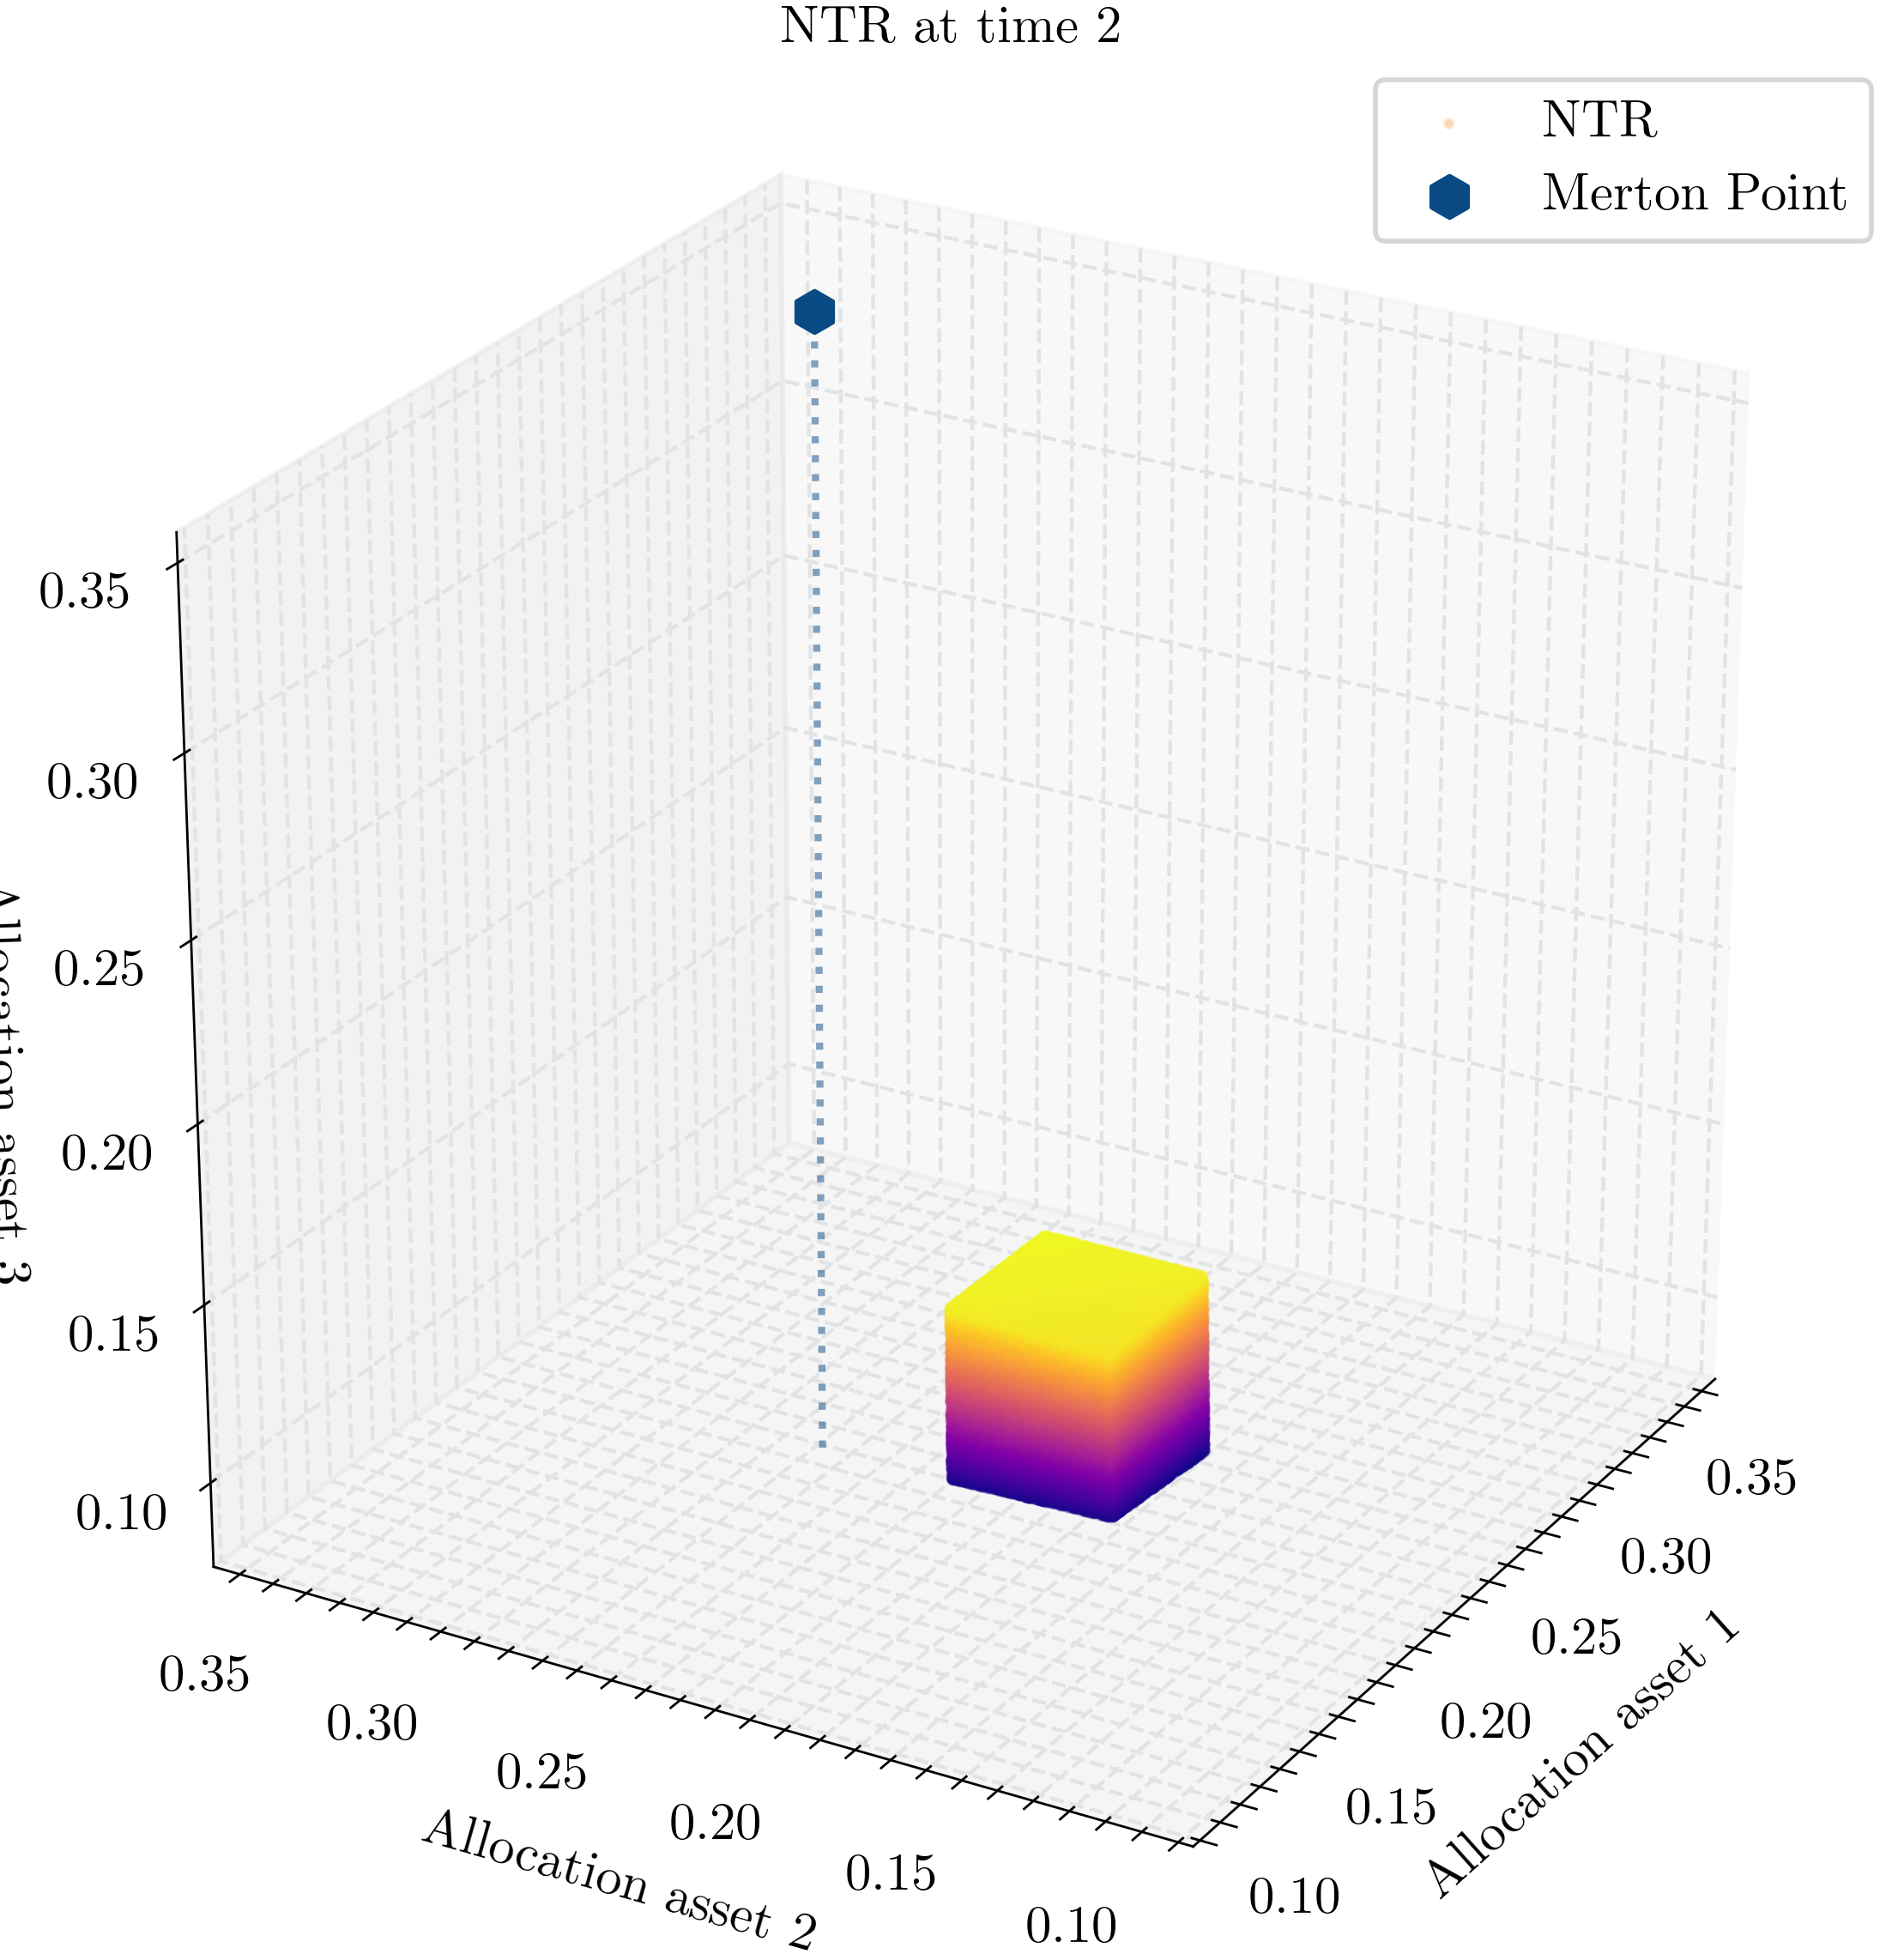

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull
import numpy as np

def sample_points_on_faces(vertices, faces, num_samples=5100):
    """
    Uniformly sample points on the faces of a convex hull.

    Parameters:
    - vertices: The vertices of the convex hull.
    - faces: The simplices (triangular faces) of the convex hull.
    - num_samples: Number of points to sample.

    Returns:
    - sampled_points: Array of sampled points on the hull's surfaces.
    - face_indices: Array of face indices corresponding to the sampled points.
    """
    sampled_points = []
    face_indices = []
    
    for i, simplex in enumerate(faces):
        # Get the vertices of the face
        face_vertices = vertices[simplex]

        # Generate random barycentric coordinates
        u = np.random.rand(num_samples, 1)
        v = np.random.rand(num_samples, 1)
        mask = u + v > 1
        u[mask] = 1 - u[mask]
        v[mask] = 1 - v[mask]
        w = 1 - u - v

        # Compute the sampled points using barycentric interpolation
        samples = u * face_vertices[0] + v * face_vertices[1] + w * face_vertices[2]
        sampled_points.append(samples)
        face_indices.extend([i] * num_samples)

    sampled_points = np.vstack(sampled_points)
    face_indices = np.array(face_indices)
    return sampled_points, face_indices

def plot_ntr_at_time(NTR_history, t, cmap='plasma'):
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
        D = vertices.shape[1]  # Dimension of the state space
        plt.figure(figsize=(8,6),dpi=400)

        if D == 2:
            # 2D plot
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color = colors[1], alpha=0.2,label='NTR')
            plt.title(f'Solution at time {t}')
            plt.scatter(merton_p[0], merton_p[1],label='Merton Point',s=100)
            plt.legend()
            plt.xlabel('Allocation risky asset 1')
            plt.ylabel('Allocation risky asset 2')
            x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
            y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
            plt.xlim(x_min - 0.1, x_max + 0.1)
            plt.ylim(y_min - 0.1, y_max + 0.1)
            plt.grid(alpha=0.5)
            save_figure_with_filename(filename[:-4], t, output_folder='../Speciale dokumentet/Figures')

        if D == 3:
            # 3D plot
            ax = plt.axes(projection='3d')
            # ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color=colors[1], alpha=0.5, s=10, marker='o')

            # Sample points on the faces
            faces = hull.simplices
            sampled_points, face_indices = sample_points_on_faces(vertices, faces)

            # Calculate color values for the sampled points
            z_values = sampled_points[:, 2]  # Use z-coordinates for coloring
            norm = plt.Normalize(vmin=z_values.min(), vmax=z_values.max())
            colormap = plt.cm.get_cmap(cmap)
            face_colors = colormap(norm(z_values))

            # Plot sampled points with colormap
            ax.scatter(
                sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2],
                color=face_colors, alpha=0.25, s=2, label='NTR'
            )

            # Highlight the Merton point and add a stem
            ax.scatter(
                merton_p[0], merton_p[1], merton_p[2], marker='h',
                color=colors[0], s=75, label='Merton Point'
            )
            ax.plot(
                [merton_p[0], merton_p[0]],  # x-coordinates
                [merton_p[1], merton_p[1]],  # y-coordinates
                [0, merton_p[2]],            # z-coordinates (from base to the point)
                color=colors[0], linestyle='dotted', linewidth=1.5,alpha=0.5
            )


            # Set axis labels and limits
            ax.set_xlabel('Allocation asset 1')
            ax.set_ylabel('Allocation asset 2')
            ax.set_zlabel('Allocation asset 3')
            plt.title(f'NTR at time {t}',pad=0.0)
            x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
            y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
            z_min, z_max = vertices[:, 2].min(), vertices[:, 2].max()

            # If merton point has higer max value use that
            if merton_p is not None:
                x_max = max(x_max, merton_p[0])
                y_max = max(y_max, merton_p[1])
                z_max = max(z_max, merton_p[2])

            ax.set_xlim(x_min - 0.05, x_max + 0.025)
            ax.set_ylim(y_min - 0.05, y_max + 0.025)
            ax.set_zlim(z_min - 0.05, z_max + 0.025)
            ax.view_init(elev=25, azim=210)
            ax.set_box_aspect([1.0, 1.0, 1.0])  # Aspect ratio for X, Y, Z                

            ax.legend()
            if save_figure:
                save_figure_with_filename(filename[:-4], t, output_folder='../Speciale dokumentet/Figures')
        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

if plot_single_time and include_consumption:
    if D < 4 and D > 0:
        t = len(NTR) - 4
        # t = 2
        # Example: Plot NTR at time t=1
        plot_ntr_at_time(NTR,t)

# Plot NTR at every time point. With Consumption!

Figure saved to ../Speciale dokumentet/Figures/NTR_Cai_High_Correlation_d2_tau_0.005__with_consumption_Over_Time_t_5.png


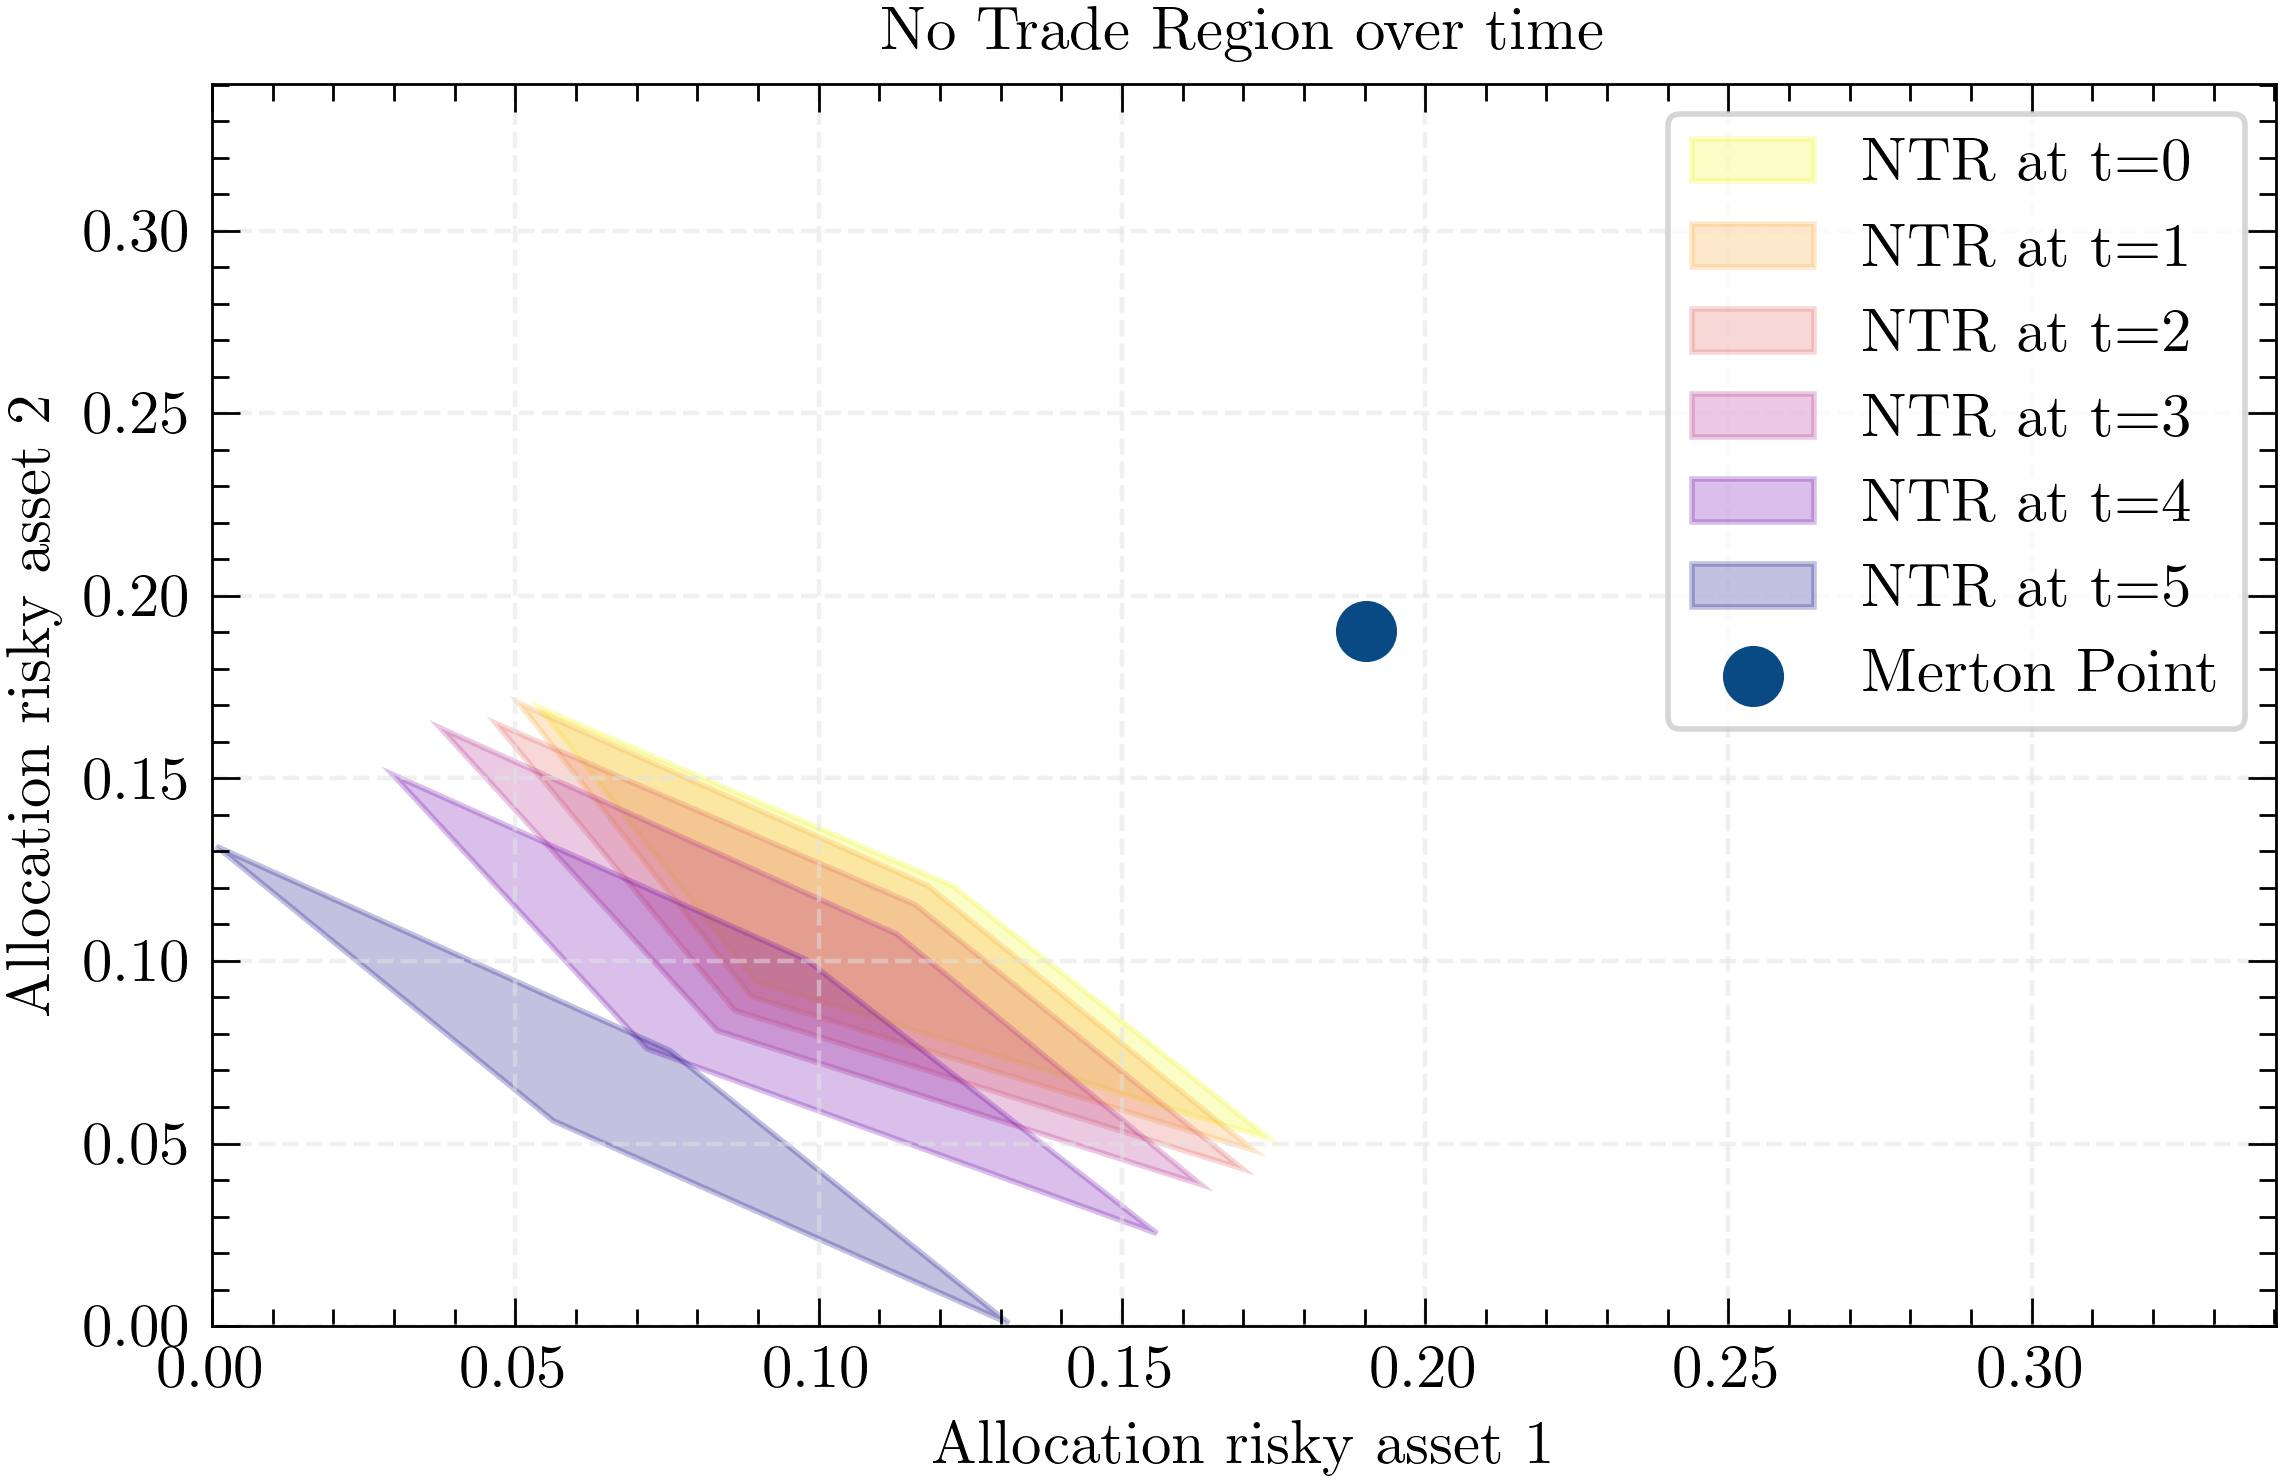

In [9]:
def save_figure_with_filename(base_filename, t, output_folder='../Speciale dokumentet/Figures'):
    """
    Saves the figure with the given filename structure and adds '_t_{t}'.

    Parameters:
    - base_filename: The base filename to use.
    - t: The time period to append to the filename.
    - output_folder: The folder to save the figure in.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Construct the full filename
    figure_filename = f"{base_filename}_t_{t}.png"
    full_path = os.path.join(output_folder, figure_filename)
    # Force the rendering of the current figure (important for 3D plots)
    plt.gcf().canvas.draw()

    # Save the figure
    plt.savefig(full_path, bbox_inches='tight')
    print(f"Figure saved to {full_path}")


def sample_points_on_faces(vertices, faces, num_samples=5100):
    """
    Uniformly sample points on the faces of a convex hull.

    Parameters:
    - vertices: The vertices of the convex hull.
    - faces: The simplices (triangular faces) of the convex hull.
    - num_samples: Number of points to sample.

    Returns:
    - sampled_points: Array of sampled points on the hull's surfaces.
    - face_indices: Array of face indices corresponding to the sampled points.
    """
    sampled_points = []
    face_indices = []
    
    for i, simplex in enumerate(faces):
        # Get the vertices of the face
        face_vertices = vertices[simplex]

        # Generate random barycentric coordinates
        u = np.random.rand(num_samples, 1)
        v = np.random.rand(num_samples, 1)
        mask = u + v > 1
        u[mask] = 1 - u[mask]
        v[mask] = 1 - v[mask]
        w = 1 - u - v

        # Compute the sampled points using barycentric interpolation
        samples = u * face_vertices[0] + v * face_vertices[1] + w * face_vertices[2]
        sampled_points.append(samples)
        face_indices.extend([i] * num_samples)

    sampled_points = np.vstack(sampled_points)
    face_indices = np.array(face_indices)
    return sampled_points, face_indices

def plot_all_ntrs_single_plot(NTR_history, merton_p, colormaps=None, buffer=0.1,save_figure=False):
    """
    Plots all convex hulls in the NTR_history list in a single plot, with each NTR using a unique colormap.

    Parameters:
        NTR_history (list): A list of ConvexHull objects representing the NTRs at different time points.
        merton_p (array): Coordinates of the Merton point.
        colormaps (list): List of colormaps to cycle through. Default is provided.
        buffer (float): Buffer to add around the Merton point for axis limits.
    """
    # Default colormap list
    if colormaps is None:
        colormaps = ['spring', 'summer', 'autumn', 'winter', 'cool', 
                     'hot', 'plasma', 'copper', 'Wistia', 'pink']

    # Create a Plasma colormap and sample distinct colors
    num_colors=len(NTR_history)
    plasma_cmap = plt.cm.plasma
    color_indices = np.linspace(0, 1, num_colors)
    colorss = [plasma_cmap(ci) for ci in color_indices[::-1]]
    reversed_colors = [plasma_cmap(ci) for ci in color_indices[::-1]]  # Reverse colormap

    # Determine the dimensionality (assumes all convex hulls are of the same dimension)
    for hull in NTR_history:
        if hull is not None:
            D = hull.points.shape[1]
            break
    else:
        print("No valid convex hulls in NTR_history to plot.")
        return

    plt.figure(figsize=(6, 4), dpi=400)

    if D == 2:
        # 2D Plot
        for t, hull in enumerate(NTR_history):
            if hull is not None:
                vertices = hull.points
                color = reversed_colors[t % num_colors]  # Use reversed colormap
                # cmap = colormaps[t % len(colormaps)]  # Cycle through colormaps
                plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 
                        # color=plt.cm.get_cmap(cmap)(0.6),
                        color=color,
                        alpha=0.25, label=f'NTR at t={t}')


        plt.scatter(merton_p[0], merton_p[1], label='Merton Point', s=100, color=colors[0], marker='o')
        plt.xlabel('Allocation risky asset 1')
        plt.ylabel('Allocation risky asset 2')
        x_max = merton_p[0] + buffer
        y_max = merton_p[1] + buffer
        plt.xlim(0.0, x_max+0.05)
        plt.ylim(0.0, y_max+0.05)
        plt.title('No Trade Region over time')
        plt.legend()
        plt.grid(alpha=0.5)

    elif D == 3:
        # 3D Plot
        ax = plt.axes(projection='3d')

        # for t, hull in enumerate(NTR_history):
        #     if hull is not None:
        #         vertices = hull.points
        #         faces = hull.simplices
        #         cmap = colormaps[t % len(colormaps)]  # Cycle through colormaps

        #         # Sample points on the faces
        #         sampled_points, face_indices = sample_points_on_faces(vertices, faces)

        #         # Calculate color values for the sampled points
        #         z_values = sampled_points[:, 2]  # Use z-coordinates for coloring
        #         norm = plt.Normalize(vmin=z_values.min(), vmax=z_values.max())
        #         colormap = plt.cm.get_cmap(cmap)
        #         face_colors = colormap(norm(z_values))

        #         # Plot sampled points with colormap
        #         ax.scatter(
        #             sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2],
        #             color=face_colors, alpha=0.1, s=2, label=f'NTR at t={t}'
        #         )

        for t, hull in enumerate(NTR_history):
            if hull is not None:
                vertices = hull.points
                faces = hull.simplices
                color = colorss[t % num_colors]  # Cycle through Plasma colors

                # Sample points on the faces
                sampled_points, face_indices = sample_points_on_faces(vertices, faces)

                # Plot sampled points with a uniform color
                ax.scatter(
                    sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2],
                    color=color, alpha=0.2, s=2, label=f'NTR at t={t}'
                )

        # Highlight the Merton point
        ax.scatter(merton_p[0], merton_p[1], merton_p[2], color=colors[0], s=75, marker='h', label='Merton Point')

        # Axis labels and limits
        ax.set_xlabel('Allocation asset 1')
        ax.set_ylabel('Allocation asset 2')
        ax.set_zlabel('Allocation asset 3')
        x_max = merton_p[0] + buffer
        y_max = merton_p[1] + buffer
        z_max = merton_p[2] + buffer
        ax.set_xlim(0.0, x_max)
        ax.set_ylim(0.0, y_max)
        ax.set_zlim(0.0, z_max)
        ax.view_init(elev=25, azim=75)
        ax.set_box_aspect([1.0, 1.0, 1.0])  # Aspect ratio for X, Y, Z
        plt.title('NTRs Across All Time Points (3D)')
        ax.legend()

    if save_figure:
        save_figure_with_filename(filename[:-4]+'_Over_Time', 5, output_folder='../Speciale dokumentet/Figures')
    plt.show()

plot_all_ntrs_single_plot(NTR, merton_p,save_figure=True)

## Select dimensions

In [58]:
NTR[4].points

array([[0.10813041, 0.11096767, 0.1096449 ],
       [0.14524517, 0.10980367, 0.10795702],
       [0.10689485, 0.1480823 , 0.10765795],
       [0.10634031, 0.10813053, 0.1456192 ],
       [0.14562457, 0.14824981, 0.10704924],
       [0.14615034, 0.10794722, 0.14630473],
       [0.10608622, 0.14730087, 0.14409587],
       [0.14675323, 0.14776453, 0.14511044]])

# Look into the NTR over time

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import numpy as np

def plot_ntr_all_times(NTR_history, dims=(0, 1), merton_p=None):
    plt.figure(figsize=(6, 4), dpi=400)

    # Dynamically generate colors using the plasma colormap
    cmap = plt.cm.plasma
    num_timepoints = len(NTR_history)
    colors_plasma = [cmap(i / num_timepoints) for i in range(num_timepoints)]

    # Loop through all time points and plot
    for t, hull in enumerate(NTR_history):
        if hull is not None:
            vertices = hull.points
            plt.fill(
                vertices[hull.vertices, dims[0]],
                vertices[hull.vertices, dims[1]],
                color=to_rgba(colors_plasma[-1-t], alpha=0.6-t*0.1),
                label=f'NTR$_{{T-{len(NTR_history)-t}}}$'            )

    # Plot Merton point if provided
    if merton_p is not None:
        plt.scatter(
            merton_p[0], merton_p[1], color=colors[0],
            s=100, label='Merton Point', zorder=5, alpha=1.0
        )

    # Adjust plot limits based on the data
    x_min, x_max = vertices[:, 0].min(), NTR_history[-1].points[:, 0].max()
    y_min, y_max = vertices[:, 1].min(), NTR_history[-1].points[:, 1].max()

    # If merton point has higer max value use that
    if merton_p is not None:
        x_max = max(x_max, merton_p[0])
        y_max = max(y_max, merton_p[1])

    # if x or y min are less than 0.1 set them to 0.1
    if x_min < 0.1:
        x_min = 0.1
    if y_min < 0.1:
        y_min = 0.1

    plt.xlim(x_min - 0.1, x_max + 0.1)
    plt.ylim(y_min - 0.1, y_max + 0.1)

    # Set axis labels, title, and legend
    plt.xlabel('Allocation risky asset 1')
    plt.ylabel('Allocation risky asset 2')
    plt.title('No Trade Region Over Time')
    plt.legend(loc='best', fontsize='small')
    plt.grid(alpha=0.3)
    # save_figure_with_filename(filename[:-4]+'_Over_Time', t, output_folder='../Speciale dokumentet/Figures')
    plt.show()

# Example Usage
# Assuming NTR is your array of ConvexHull objects
# and merton_p is defined (e.g., merton_p = [0.5, 0.5])
if plot_over_time:
    plot_ntr_all_times(NTR_history=NTR, dims=(0, 1), merton_p=merton_p)

## NTR for different $\tau$

In [60]:
import os
import pickle
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Function to load NTR from files
def load_ntr_array_from_file(filename):
    """
    Loads the NTR array from a pickle file.

    Parameters:
    - filename: The name of the file to load.

    Returns:
    - The NTR array (list of ConvexHull objects or None).
    """
    # Ensure the "NTRs" folder exists
    os.makedirs("NTRs", exist_ok=True)

    # Construct the full file path
    full_filename = os.path.join("NTRs", filename)

    with open(full_filename, "rb") as file:
        NTR = pickle.load(file)
    print(f"NTR array loaded from {full_filename}")
    return NTR


def plot_multiple_ntrs(NTR_history_list, taus, dims=(0, 1), merton_p=None):
    """
    Plots multiple NTRs at time period 0 for different values of tau on the same figure.

    Parameters:
    - NTR_history_list: List of lists of ConvexHull objects for different tau values.
    - taus: List of tau values corresponding to NTR_history_list.
    - dims: Tuple of dimensions to plot (default: (0, 1) for 2D plots).
    - merton_p: Coordinates of the Merton point (optional).
    """
    plt.figure(figsize=(6, 4), dpi=400)

    # Colors for the regions
    colors = ['#094a84', '#cc2300', '#009437', '#cc7700',
              '#694878', '#383838', '#7e7e7e']
    
    cmap = plt.cm.plasma
    num_timepoints = len(NTR_history_list)
    colors_plasma = [cmap(i / num_timepoints) for i in range(num_timepoints)]

    # Determine global axis limits
    x_min_global, x_max_global = float('inf'), float('-inf')
    y_min_global, y_max_global = float('inf'), float('-inf')

    for NTR_history in NTR_history_list:
        hull = NTR_history[4]  # Time period 0
        if hull is not None:
            vertices = hull.points
            x_min_global = min(x_min_global, vertices[:, dims[0]].min())
            x_max_global = max(x_max_global, vertices[:, dims[0]].max())
            y_min_global = min(y_min_global, vertices[:, dims[1]].min())
            y_max_global = max(y_max_global, vertices[:, dims[1]].max())

    # Add padding to the global limits
    x_min_global -= 0.1
    x_max_global += 0.15
    y_min_global -= 0.1
    y_max_global += 0.15

    # # Plot each NTR
    # for i, (NTR_history, tau) in enumerate(zip(NTR_history_list, taus)):
    #     hull = NTR_history[4]  # Time period 0
    #     if hull is not None:
    #         vertices = hull.points
    #         plt.fill(
    #             vertices[hull.vertices, dims[0]],
    #             vertices[hull.vertices, dims[1]],
    #             color=colors[i+2], alpha=0.4-i*0.1,
    #             label=f'$\\tau = {tau}$'
    #         )

    # # Plot Merton point if provided
    # if merton_p is not None:
    #     plt.scatter(
    #         merton_p[0], merton_p[1],
    #         s=75, label='Merton Point', zorder=5
    #     )

# Plot each NTR
    for i, (NTR_history, tau) in enumerate(zip(NTR_history_list, taus)):
        hull = NTR_history[4]  # Time period 0
        if hull is not None:
            vertices = hull.points
            plt.fill(
                vertices[hull.vertices, dims[0]],
                vertices[hull.vertices, dims[1]],
                color=colors_plasma[-i], alpha=0.1 + i * 0.1,
                label=f'$\\tau = {tau}$'
            )

    # Plot Merton point if provided
    if merton_p is not None:
        plt.scatter(
            merton_p[0], merton_p[1],
            color=colors[0],  # Keep Merton Point color fixed
            s=75, label='Merton Point', zorder=5
        )        

    # Set axis limits, labels, title, and legend
    plt.xlim(x_min_global, x_max_global)
    plt.ylim(y_min_global, y_max_global)
    plt.xlabel('Allocation risky asset 1')
    plt.ylabel('Allocation risky asset 2')
    plt.title('No Trade Regions for Different $\\tau$ Values at $t=3$')
    plt.legend(loc='best', fontsize='small')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    save_figure_with_filename('NTR_'+filename_prefix + 'Different_Tau', 3, output_folder='../Speciale dokumentet/Figures')
    plt.show()


# Main logic
if plot_taus:
    # Define parameters
    taus = [0.01,0.005,0.002,0.001]
    D = 2  # Dimension of the state space
    filename_prefix = "Cai_Identical"
    include_consumption = False

    # Consumption suffix
    if include_consumption:
        consumption = "_with_consumption"
    else:
        consumption = "_no_consumption"

    # Load NTR arrays for each tau
    NTR_history_list = []
    for tau in taus:
        filename = f"NTR_{filename_prefix}_d{D}_tau_{tau}_{consumption}.pkl"
        NTR_history = load_ntr_array_from_file(filename)
        NTR_history_list.append(NTR_history)

    # Compute the Merton point (already defined in your code)
    mu = [0.07] * D
    Sigma = [[0.04 if i == j else 0.00 for j in range(D)] for i in range(D)]
    gamma = 3.0
    r = np.log(np.round(np.exp(0.0301),4))
    Sigma = np.array(Sigma)
    mu = np.array(mu)

    def MertonPoint(mu, Sigma, r, gamma):
        Sigma_inv = np.linalg.inv(Sigma)
        mu_r = mu - r
        pi_star = (1.0 / gamma) * Sigma_inv.dot(mu_r)
        return pi_star

    merton_p = MertonPoint(mu, Sigma, r, gamma)

    # Plot the NTRs for different taus
    plot_multiple_ntrs(NTR_history_list=NTR_history_list, taus=taus, dims=(0, 1), merton_p=merton_p)